In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  # "amazon/chronos-t5-tiny",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

In [84]:
from utils import get_data
import warnings
warnings.filterwarnings("ignore")
quarterly_data, monthly_data, weekly_data, daily_data = get_data('2015-01-01', '9999-01-01')

In [85]:
# quarterly_data

In [86]:
df = pd.DataFrame()
# df['d_ln_avg_efficiency'] = quarterly_data['d_ln_avg_efficiency']
# df['d_ln_open_price'] = quarterly_data['d_ln_open_price']
# df['d_ln_avg_efficiency'] = quarterly_data['ln_avg_efficiency']+12
df['d_ln_open_price'] = quarterly_data['ln_open_price']
df['cost'] = quarterly_data['cost']
df['d_cost'] = quarterly_data['d_cost']
# drop index
df = df.reset_index(drop=True)

In [87]:
test_size = 8
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]
print(len(train), len(test))

22 8


In [88]:
test

,d_ln_open_price,cost,d_cost
22,9.270672,0.322974,0.025749
23,9.717581,0.309016,-0.013959
24,10.718264,0.115548,-0.193468
25,10.751871,0.095822,-0.019726
26,10.640330,0.071940,-0.023882
27,10.934922,0.070699,-0.001241
28,10.631699,0.125531,0.054832
29,10.394331,0.183824,0.058292


In [89]:
# Initialize context with training data
context1 = torch.tensor(train["d_ln_open_price"], dtype=torch.float32)
context2 = torch.tensor(train["cost"], dtype=torch.float32)
context3 = torch.tensor(train["d_cost"], dtype=torch.float32)


# Lists to collect predictions
predictions_cost = []
predictions_d_cost = []
predictions_d_ln_open_price = []

# Predict one step at a time
for i in range(len(test)):
    forecast = pipeline.predict([
        context1, 
        context2, 
        context3
        ], prediction_length=1)
    

    predictions_d_ln_open_price.append(np.quantile(forecast[0].numpy(), 0.5, axis=0).item())
    predictions_cost.append(np.quantile(forecast[1].numpy(), 0.5, axis=0).item())
    predictions_d_cost.append(np.quantile(forecast[1].numpy(), 0.5, axis=0).item())

    context1 = torch.cat([context1, torch.tensor([test.iloc[i]["d_ln_open_price"]], dtype=torch.float32)])
    context2 = torch.cat([context2, torch.tensor([test.iloc[i]["cost"]], dtype=torch.float32)])
    context3 = torch.cat([context3, torch.tensor([test.iloc[i]["d_cost"]], dtype=torch.float32)])
    

# Convert predictions to numpy arrays for plotting
predictions_d_ln_open_price = np.array(predictions_d_ln_open_price)
predictions_cost = np.array(predictions_cost)
predictions_d_cost = np.array(predictions_d_cost)




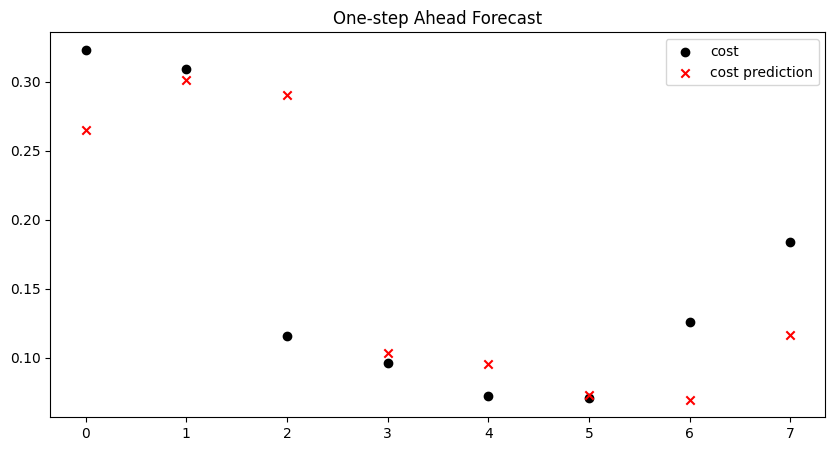

In [90]:
# Plotting the results
plt.figure(figsize=(10, 5))

plt.scatter(range(len(test)), test["cost"], label="cost", color="black", marker='o')
plt.scatter(range(len(test)), predictions_cost, label="cost prediction", color="red", marker='x')

plt.legend()
plt.title("One-step Ahead Forecast")
plt.show()

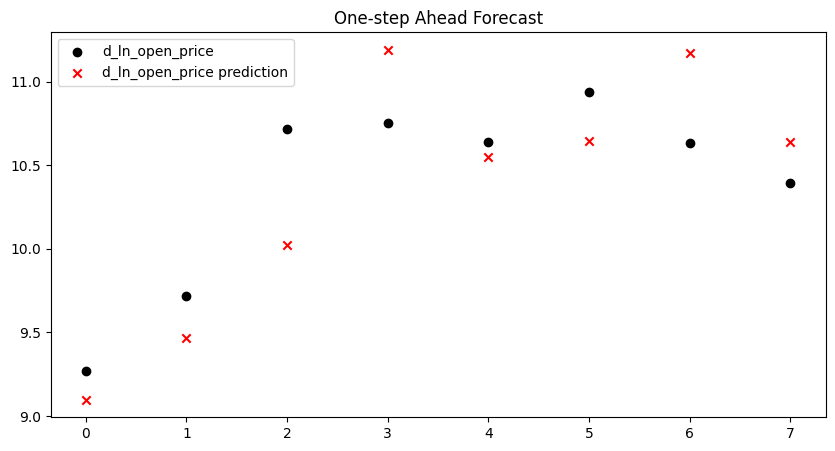

In [91]:
# Plotting the results
plt.figure(figsize=(10, 5))

plt.scatter(range(len(test)), test["d_ln_open_price"], label="d_ln_open_price", color="black", marker='o')
plt.scatter(range(len(test)), predictions_d_ln_open_price, label="d_ln_open_price prediction", color="red", marker='x')

plt.legend()
plt.title("One-step Ahead Forecast")
plt.show()

In [92]:
# print("average prediction error for cost: ", np.mean(np.abs(predictions_cost - test["cost"].values)))
# print("average prediction error for d_cost: ", np.mean(np.abs(predictions_d_cost - test["d_cost"].values)))
# print("average prediction error for d_ln_open_price: ", np.mean(np.abs(predictions_d_ln_open_price - test["d_ln_open_price"].values)))

from sklearn.metrics import mean_squared_error
print("average prediction mean_squared_error for cost: ", mean_squared_error(predictions_cost, test["cost"].values))
# print("average prediction mean_squared_error for d_cost: ", mean_squared_error(predictions_d_cost, test["d_cost"].values))
print("average prediction mean_squared_error for d_ln_open_price: ", mean_squared_error(predictions_d_ln_open_price, test["d_ln_open_price"].values))

average prediction mean_squared_error for cost:  0.005297072993483471
average prediction mean_squared_error for d_ln_open_price:  0.151176342763728


In [93]:
# # context must be either a 1D tensor, a list of 1D tensors,
# # or a left-padded 2D tensor with batch as the first dimension
# context1 = torch.tensor(train["d_ln_avg_efficiency"])
# context2 = torch.tensor(train["d_ln_open_price"])
# context = [context1, context2]

In [94]:
# prediction_length = len(test)
# forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

In [95]:
# forecast.shape # torch.Size([2, prediction_length, prediction_length])

In [96]:
# # forecast_index = range(len(train), len(train) + prediction_length)
# forecast_index = range(len(test))
# low, median_d_ln_avg_efficiency, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
# low, median_d_ln_open_price, high = np.quantile(forecast[1].numpy(), [0.1, 0.5, 0.9], axis=0)

In [97]:
# # visualize the forecast
# plt.figure(figsize=(8, 4))
# plt.plot(np.array(df["d_ln_avg_efficiency"])[:len(test)], color="green", label="real d_ln_avg_efficiency")
# plt.plot(np.array(df["d_ln_open_price"])[:len(test)], color="blue", label="real d_ln_open_price")
# plt.plot(forecast_index, median_d_ln_avg_efficiency, color="magenta", label="median forecast")
# plt.plot(forecast_index, median_d_ln_open_price, color="tomato", label="median forecast")
# plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
# plt.legend()
# plt.grid()
# plt.show()